In [1]:
!unzip '/content/archive (5).zip'

Archive:  /content/archive (5).zip
   creating: smaller_dataset/ALter/
  inflating: smaller_dataset/ALter/1__M_Left_index_finger_CR.BMP  
  inflating: smaller_dataset/ALter/1__M_Left_index_finger_Obl.BMP  
  inflating: smaller_dataset/ALter/1__M_Left_index_finger_Zcut.BMP  
  inflating: smaller_dataset/ALter/100__M_Left_middle_finger_Obl.BMP  
  inflating: smaller_dataset/ALter/Hard (1).BMP  
  inflating: smaller_dataset/ALter/Hard (2).BMP  
  inflating: smaller_dataset/ALter/Hard (3).BMP  
  inflating: smaller_dataset/ALter/Medium (1).BMP  
  inflating: smaller_dataset/ALter/Medium (2).BMP  
  inflating: smaller_dataset/ALter/Medium (3).BMP  
   creating: smaller_dataset/Real/
  inflating: smaller_dataset/Real/1__M_Left_index_finger.BMP  
  inflating: smaller_dataset/Real/1__M_Left_little_finger.BMP  
  inflating: smaller_dataset/Real/1__M_Left_middle_finger.BMP  
  inflating: smaller_dataset/Real/1__M_Left_ring_finger.BMP  
  inflating: smaller_dataset/Real/1__M_Left_thumb_finger.BMP

Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(256), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(256), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    ])

In [4]:
pip install split-folders

In [5]:
import splitfolders

In [6]:
splitfolders.ratio('archive (5)',output='dataset',ratio=(0.7,0.3))

Copying files: 16 files [00:00, 2343.92 files/s]


In [7]:
trainset=torchvision.datasets.ImageFolder(root='/content/dataset/train',transform=transform_train)

In [8]:
testset=torchvision.datasets.ImageFolder(root='/content/dataset/val',transform=transform_test)

In [9]:
batch_size = 2

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)

In [11]:
testloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size)

In [12]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [13]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

In [14]:
 images, labels = next(iter(trainloader))

In [15]:
print(images.shape)

torch.Size([2, 3, 256, 256])


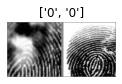

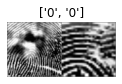

In [16]:
for i in range(batch_size):
    show_batch_images(trainloader)

In [17]:
classes=['ALter','Real']

Model_resnetxt

In [18]:
from torchvision import models

In [19]:
import torch

In [20]:
resnetxt= models.resnext50_32x4d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [21]:
print(resnetxt)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [22]:
for param in resnetxt.parameters():
    param.requires_grad = False

In [23]:
num_classes=2

In [24]:
in_features = resnetxt.fc.in_features
resnetxt.fc = torch.nn.Linear(in_features, num_classes)

In [25]:
device = torch.device("cpu")

In [26]:
resnetxt = resnetxt.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(resnetxt.parameters(), lr=3e-4)

In [27]:
import copy

In [28]:
max_epochs=10

In [29]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [32]:
def show_images(images, labels, preds):
    preds=preds.detach()
    plt.figure(figsize=(20,20))
    for i, image in enumerate(images):
        plt.subplot(1,20,i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.5])
        std = np.array([0.5])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        print(classes[int(np.argmax(preds[i].numpy()))],end=' ' )
        plt.xlabel(f'{classes[int(labels[i].numpy())]}')
    plt.tight_layout()
    plt.show()

Min loss 0.43
Iteration: 0, Loss: 0.43
ALter ALter 

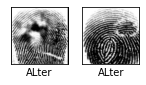

Epoch: 0/10, Test acc: 54.55, Train acc: 36.36
Iteration: 0, Loss: 0.73
Real Real 

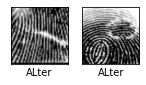

Epoch: 1/10, Test acc: 36.36, Train acc: 27.27
Iteration: 0, Loss: 0.76
Real Real 

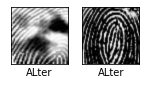

Epoch: 2/10, Test acc: 63.64, Train acc: 63.64
Iteration: 0, Loss: 0.62
ALter ALter 

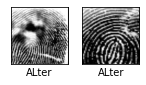

Epoch: 3/10, Test acc: 63.64, Train acc: 63.64
Iteration: 0, Loss: 0.50
ALter ALter 

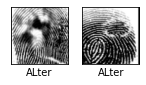

Epoch: 4/10, Test acc: 63.64, Train acc: 63.64
Iteration: 0, Loss: 0.49
ALter ALter 

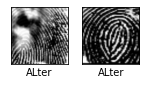

Epoch: 5/10, Test acc: 63.64, Train acc: 63.64
Iteration: 0, Loss: 0.52
ALter ALter 

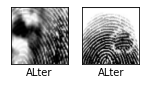

Epoch: 6/10, Test acc: 54.55, Train acc: 63.64
Iteration: 0, Loss: 0.55
ALter ALter 

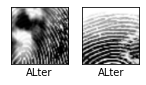

Epoch: 7/10, Test acc: 72.73, Train acc: 63.64
Iteration: 0, Loss: 0.56
ALter ALter 

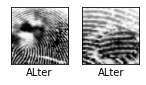

Epoch: 8/10, Test acc: 63.64, Train acc: 63.64
Iteration: 0, Loss: 0.57
ALter ALter 

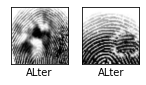

Epoch: 9/10, Test acc: 63.64, Train acc: 63.64


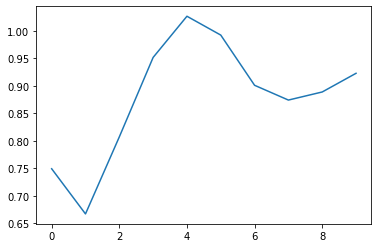

In [33]:
loss_epoch_arr = []
min_loss = 1000

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnetxt(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnetxt.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d, Loss: %0.2f' % (i,loss.item()))
            show_images(inputs,labels,outputs)
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnetxt), evaluation(trainloader, resnetxt)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [34]:
resnetxt.load_state_dict(best_model)
print(evaluation(trainloader, resnetxt), evaluation(testloader, resnetxt))

63.63636363636363 63.63636363636363


FORMAT :
1. predicted values 
2. image
3. real values